In [1]:
# ====================================
# 1. Setup
# ====================================
!pip install scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from scipy.stats import binomtest
import pickle


In [4]:
# ====================================
# 2. Load Data
# ====================================
# NOTE: Replace these with your own Colab upload paths
# You can upload by running:
# from google.colab import files
# uploaded = files.upload()

train_path = "train-train-clean.csv"   # update if your filename differs
valid_path = "valid-valid-clean.csv"

# Load CSV (no headers in LIAR dataset)
train_df = pd.read_csv(train_path, header=None, engine="python")
valid_df = pd.read_csv(valid_path, header=None, engine="python")

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)
train_df.head()


Train shape: (10240, 13)
Valid shape: (1284, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2635.json,FALSE,Says the Annies List political group supports ...,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,FALSE,Health care reform legislation is likely to ma...,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [5]:
# ====================================
# 3. Assign column names (heuristic)
# ====================================
cols = [
    "id", "label", "statement",
    "speaker", "title", "state", "party",
    "num1", "num2", "num3", "num4", "num5",
    "context"
]
train_df.columns = cols
valid_df.columns = cols

print(train_df.sample(3))


             id       label  \
9817  1256.json        TRUE   
4158  6283.json  pants-fire   
6580  9777.json        TRUE   

                                              statement            speaker  \
9817  A report by the health insurance industry "ign...  nancy-ann-deparle   
4158  Says raising the state income tax rate on mill...      lou-greenwald   
6580  New Glarus Brewing Co.s Spotted Cow is availab...         mary-burke   

                                             title       state     party  \
9817  White House Office of Health Reform Director         NaN  democrat   
4158                             State Assemblyman  New Jersey  democrat   
6580                   Madison school board member   Wisconsin  democrat   

      num1  num2  num3  num4  num5                                context  
9817   0.0   0.0   0.0   0.0   0.0         an interview on "The NewsHour"  
4158   0.0   1.0   1.0   2.0   2.0  an interview on 6abc’s “Inside Story”  
6580   5.0   5.0  11.0   8.0 

In [6]:
# ====================================
# 4. Encode labels
# ====================================
le = LabelEncoder()
train_df["label_enc"] = le.fit_transform(train_df["label"])
valid_df["label_enc"] = le.transform(valid_df["label"])

print("Classes:", list(le.classes_))


Classes: ['FALSE', 'TRUE', 'barely-true', 'half-true', 'mostly-true', 'pants-fire']


In [7]:
# ====================================
# 5. TF-IDF Baseline Model
# ====================================
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    max_features=10000
)

X_train = vectorizer.fit_transform(train_df["statement"].fillna(""))
X_valid = vectorizer.transform(valid_df["statement"].fillna(""))

y_train = train_df["label_enc"].values
y_valid = valid_df["label_enc"].values

baseline_model = LogisticRegression(
    max_iter=2000,
    solver="saga",
    multi_class="multinomial"
)
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_valid)

print("Baseline TF-IDF only")
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred, target_names=le.classes_))


Baseline TF-IDF only
Accuracy: 0.21495327102803738
              precision    recall  f1-score   support

       FALSE       0.26      0.32      0.28       263
        TRUE       0.19      0.22      0.21       169
 barely-true       0.18      0.14      0.16       237
   half-true       0.18      0.23      0.20       248
 mostly-true       0.24      0.24      0.24       251
  pants-fire       0.32      0.05      0.09       116

    accuracy                           0.21      1284
   macro avg       0.23      0.20      0.20      1284
weighted avg       0.22      0.21      0.21      1284



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


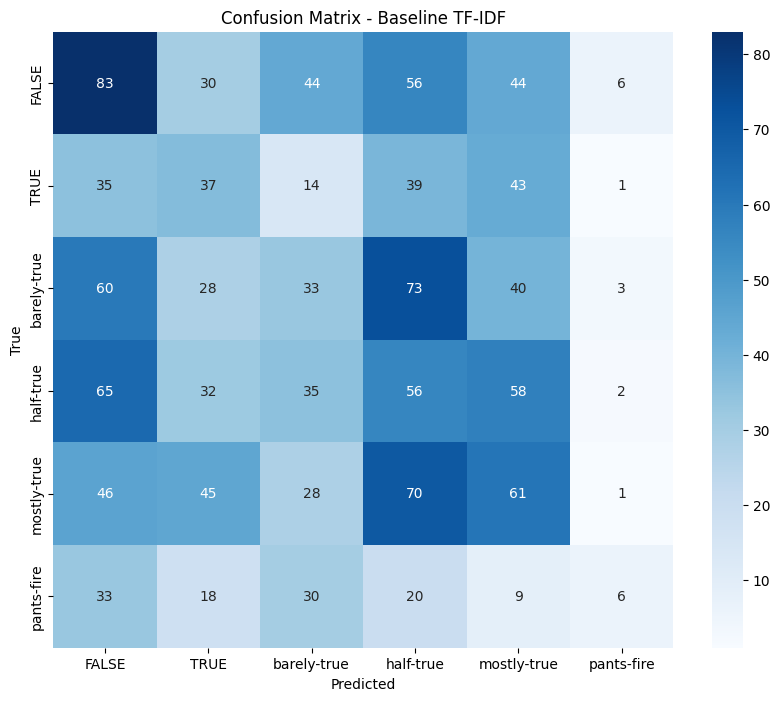

In [8]:
# ====================================
# 6. Confusion Matrix
# ====================================
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Baseline TF-IDF")
plt.show()


In [11]:
# ====================================
# 7. Add Metadata Features (fixed)
# ====================================
# One-hot encode categorical metadata (party, state, context)
meta_df_train = pd.get_dummies(
    train_df[["party", "state", "context"]].fillna("unknown"),
    drop_first=True
).astype(float)

meta_df_valid = pd.get_dummies(
    valid_df[["party", "state", "context"]].fillna("unknown"),
    drop_first=True
).astype(float)

# Align columns (important!)
meta_df_valid = meta_df_valid.reindex(columns=meta_df_train.columns, fill_value=0)

# Combine TF-IDF + metadata
from scipy.sparse import hstack
X_train_combined = hstack([X_train, meta_df_train.values])
X_valid_combined = hstack([X_valid, meta_df_valid.values])

combined_model = LogisticRegression(
    max_iter=2000,
    solver="saga",
    multi_class="multinomial"
)
combined_model.fit(X_train_combined, y_train)

y_pred_meta = combined_model.predict(X_valid_combined)

print("TF-IDF + Metadata")
print("Accuracy:", accuracy_score(y_valid, y_pred_meta))
print(classification_report(y_valid, y_pred_meta, target_names=le.classes_))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


TF-IDF + Metadata
Accuracy: 0.26557632398753894
              precision    recall  f1-score   support

       FALSE       0.28      0.35      0.31       263
        TRUE       0.23      0.23      0.23       169
 barely-true       0.22      0.16      0.19       237
   half-true       0.24      0.29      0.27       248
 mostly-true       0.30      0.30      0.30       251
  pants-fire       0.45      0.19      0.27       116

    accuracy                           0.27      1284
   macro avg       0.29      0.26      0.26      1284
weighted avg       0.27      0.27      0.26      1284



In [12]:
# ====================================
# 8. Hypothesis Test
# H0: Accuracy <= 75%
# H1: Accuracy > 75%
# ====================================
n = len(y_valid)
k_baseline = sum(y_pred == y_valid)
k_meta = sum(y_pred_meta == y_valid)

test_baseline = binomtest(k_baseline, n, p=0.75, alternative="greater")
test_meta = binomtest(k_meta, n, p=0.75, alternative="greater")

print("Baseline accuracy:", k_baseline / n, "p-value:", test_baseline.pvalue)
print("Meta accuracy:", k_meta / n, "p-value:", test_meta.pvalue)


Baseline accuracy: 0.21495327102803738 p-value: 1.0
Meta accuracy: 0.26557632398753894 p-value: 1.0


In [13]:
# ====================================
# 9. Save Models/Artifacts (optional)
# ====================================
artifacts = {
    "vectorizer": vectorizer,
    "label_encoder": le,
    "baseline_model": baseline_model,
    "combined_model": combined_model,
    "meta_columns": meta_df_train.columns.tolist()
}

# with open("liar_artifacts.pkl", "wb") as f:
#     pickle.dump(artifacts, f)

# print("Artifacts saved as liar_artifacts.pkl")


In [14]:
# Top TF-IDF words per class (baseline)
feature_names = vectorizer.get_feature_names_out()
coefs = baseline_model.coef_  # shape (n_classes, n_features)
topk = 20
for i, cls in enumerate(le.classes_):
    top_idx = np.argsort(coefs[i])[-topk:][::-1]
    top_words = [feature_names[j] for j in top_idx]
    print(f"\nClass: {cls} — top {topk} words:")
    print(top_words[:30])

# Top features from combined model (TF-IDF + metadata)
if 'combined_model' in globals():
    tfidf_count = len(feature_names)
    meta_names = list(meta_df_train.columns)
    combined_names = list(feature_names) + meta_names
    coefs_comb = combined_model.coef_
    for i, cls in enumerate(le.classes_):
        top_idx = np.argsort(coefs_comb[i])[-30:][::-1]
        top_feats = [(combined_names[j], float(coefs_comb[i, j])) for j in top_idx]
        # split into textual and metadata for readability
        top_text = [name for name, coef in top_feats if combined_names.index(name) < tfidf_count][:15]
        top_meta = [name for name, coef in top_feats if combined_names.index(name) >= tfidf_count][:15]
        print(f"\nClass {cls}: top textual words (sample): {top_text[:10]}")
        print(f"Class {cls}: top metadata features (sample): {top_meta[:10]}")



Class: FALSE — top 20 words:
['worked', 'destroyed', 'scheme', 'building', 'debunked', 'budget', 'vice', 'attack', 'taxed', 'legislative', 'bankrupt', 'numbers', 'cicilline', 'commission', 'terry', 'raise', 'government', 'mcauliffe', 'supporter', 'trillions']

Class: TRUE — top 20 words:
['mccain', 'georgia', 'counties', 'compensation', 'representatives', 'affect', 'half', 'day', 'words', 'american', 'wealth', 'worth', 'heavily', 'members', 'called', 'georgias', 'supreme', 'died', 'state', 'flip']

Class: barely-true — top 20 words:
['fight', 'real', 'clear', 'benghazi', 'obamacare', 'modern', 'deciding', 'supports', 'card', 'taxpayer', 'voted', 'arent', 'know', 'stop', 'pass', 'rob', 'offenders', 'patients', 'foundation', 'high']

Class: half-true — top 20 words:
['indiana', 'santorum', 'cut', 'standards', 'anytime', 'millions', 'work', 'comes', 'break', 'black', 'thanks', 'housing', 'increased', 'administration', 'ask', 'trillion', 'minnesota', 'dropout', 'countries', 'manufacturing

In [15]:
def collapse_label(lbl):
    if lbl in ["true", "mostly-true"]:
        return "true"
    else:
        return "not_true"

train_df["label_bin"] = train_df["label"].apply(collapse_label)
valid_df["label_bin"] = valid_df["label"].apply(collapse_label)

le_bin = LabelEncoder()
y_train_bin = le_bin.fit_transform(train_df["label_bin"])
y_valid_bin = le_bin.transform(valid_df["label_bin"])
# then retrain vectorizer and model as above


Using device: cuda
Train shape: (10240, 13)
Valid shape: (1284, 13)
Sample data:
         label                                          statement       party  \
0        FALSE  Says the Annies List political group supports ...  republican   
1    half-true  When did the decline of coal start? It started...    democrat   
2  mostly-true  Hillary Clinton agrees with John McCain "by vo...    democrat   
3        FALSE  Health care reform legislation is likely to ma...        none   
4    half-true  The economic turnaround started at the end of ...    democrat   

      state  
0     Texas  
1  Virginia  
2  Illinois  
3       NaN  
4   Florida  
Sample cleaned statements:
1: Says the Annies List political group supports third-trimester abortions on demand....
2: When did the decline of coal start? It started when natural gas took off that started to begin in (P...
3: Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on I...
Label classes: ['F

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Generating BERT embeddings for training data...
Training embeddings shape: (10240, 768)
Generating BERT embeddings for validation data...
Validation embeddings shape: (1284, 768)
Training baseline model with BERT features...

Baseline BERT Model Results:
Accuracy: 0.2492

Classification Report:
              precision    recall  f1-score   support

       FALSE       0.28      0.30      0.29       263
        TRUE       0.21      0.24      0.22       169
 barely-true       0.20      0.18      0.19       237
   half-true       0.23      0.27      0.25       248
 mostly-true       0.28      0.27      0.28       251
  pants-fire       0.35      0.20      0.25       116

    accuracy                           0.25      1284
   macro avg       0.26      0.24      0.25      1284
weighted avg       0.25      0.25      0.25      1284



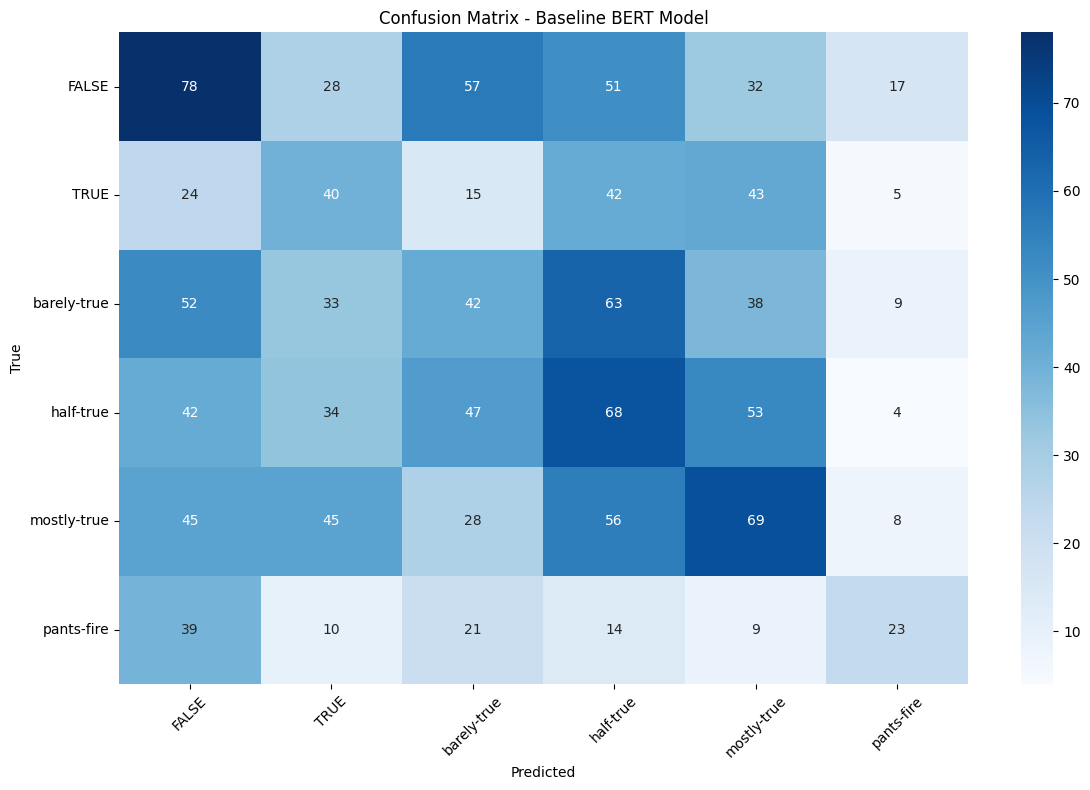

Adding metadata features...
Metadata features shape - Train: (10240, 4372), Valid: (1284, 4372)
Sample metadata columns: ['party_activist', 'party_business-leader', 'party_columnist', 'party_constitution-party', 'party_democrat', 'party_democratic-farmer-labor', 'party_education-official', 'party_government-body', 'party_green', 'party_independent']
Combined features shape - Train: (10240, 5140), Valid: (1284, 5140)
Training combined model (BERT + Metadata)...

Combined Model Results:
Accuracy: 0.2695
Improvement over baseline: 0.0202

Classification Report:
              precision    recall  f1-score   support

       FALSE       0.27      0.30      0.29       263
        TRUE       0.23      0.27      0.25       169
 barely-true       0.23      0.20      0.21       237
   half-true       0.25      0.28      0.26       248
 mostly-true       0.31      0.29      0.30       251
  pants-fire       0.41      0.28      0.34       116

    accuracy                           0.27      1284
 

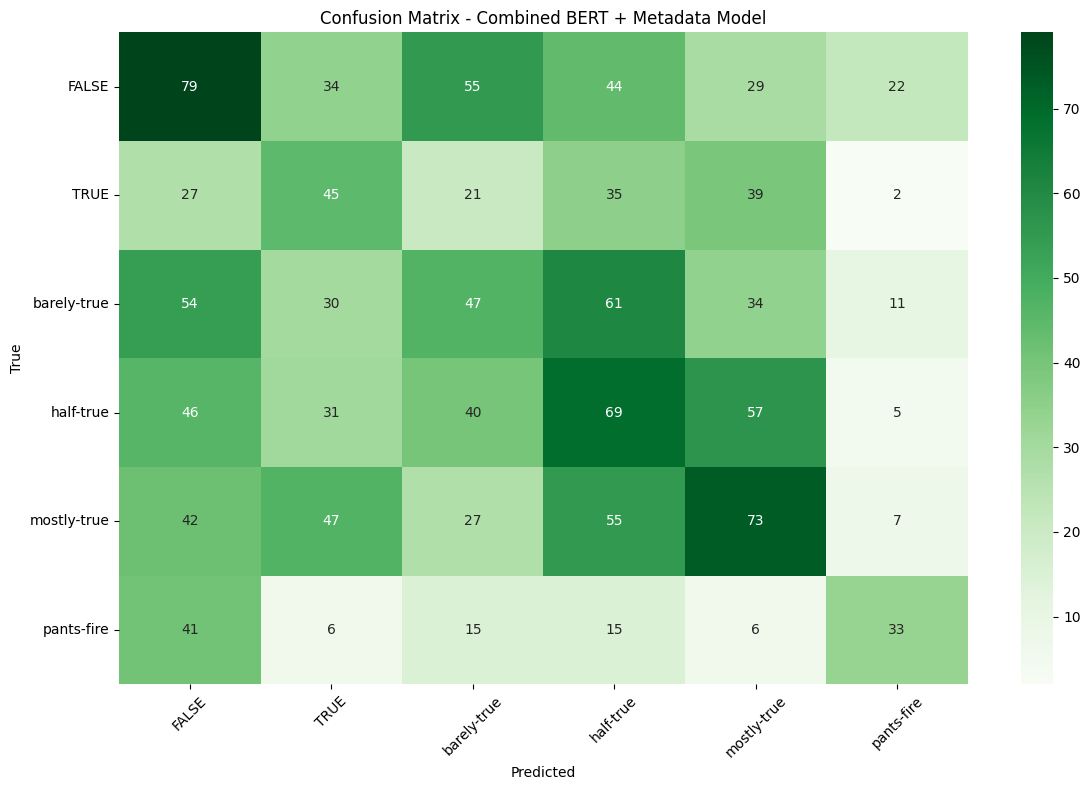

MODEL COMPARISON SUMMARY
Baseline (BERT only):           0.2492
Combined (BERT + Metadata):     0.2695
Metadata improvement:           0.0202

Hypothesis Testing (H0: accuracy ≤ 75%, H1: accuracy > 75%):
Baseline model: 320/1284 correct, p-value = 1.000000
Combined model: 346/1284 correct, p-value = 1.000000
❌ Fail to reject H0: No evidence that accuracy > 75%

TOP METADATA FEATURES BY CLASS

Class: FALSE
  Most Predictive (Positive):
    context_website posting.: 1.5298
    context_an interview on NJTV’s “On the Record”: 1.3699
    context_a TV debate: 1.2377
    context_a speech at the Brookings Institution: 1.2112
    context_a floor speech: 1.1615
  Most Predictive (Negative):
    context_an ad: -1.0726
    state_Utah: -1.0247
    context_flip-o-meter: -1.0058

Class: TRUE
  Most Predictive (Positive):
    state_Wyoming: 1.5635
    context_a newspaper column: 1.4377
    context_a newspaper commentary: 1.3632
    context_statement: 1.3413
    context_a town hall meeting in Hudson, N

In [16]:
# ====================================
# LIAR Dataset Analysis with BERT
# ====================================

# ====================================
# 1. Setup & Installation
# ====================================
!pip install transformers torch scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import binomtest
from scipy.sparse import csr_matrix, hstack
import pickle
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ====================================
# 2. Load Data
# ====================================
# Upload your files to Colab first using:
# from google.colab import files
# uploaded = files.upload()

train_path = "train-train-clean.csv"
valid_path = "valid-valid-clean.csv"

# Load CSV files
train_df = pd.read_csv(train_path, header=None, engine="python")
valid_df = pd.read_csv(valid_path, header=None, engine="python")

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)

# ====================================
# 3. Assign Column Names
# ====================================
cols = [
    "id", "label", "statement",
    "speaker", "title", "state", "party",
    "num1", "num2", "num3", "num4", "num5",
    "context"
]
train_df.columns = cols
valid_df.columns = cols

print("Sample data:")
print(train_df[['label', 'statement', 'party', 'state']].head())

# ====================================
# 4. Clean and Process Text Data
# ====================================
def clean_text(text):
    """Clean text by handling NaN and basic preprocessing"""
    if pd.isna(text):
        return ""
    return str(text).strip()

train_df['statement_clean'] = train_df['statement'].apply(clean_text)
valid_df['statement_clean'] = valid_df['statement'].apply(clean_text)

print(f"Sample cleaned statements:")
for i in range(3):
    print(f"{i+1}: {train_df['statement_clean'].iloc[i][:100]}...")

# ====================================
# 5. Encode Labels
# ====================================
le = LabelEncoder()
train_df["label_enc"] = le.fit_transform(train_df["label"])
valid_df["label_enc"] = le.transform(valid_df["label"])

print("Label classes:", list(le.classes_))
print("Label distribution:")
print(train_df['label'].value_counts())

# ====================================
# 6. BERT Text Encoding
# ====================================
# Use DistilBERT (smaller, faster than full BERT)
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)
bert_model.to(device)
bert_model.eval()

def get_bert_embeddings(texts, batch_size=16, max_length=512):
    """
    Get BERT embeddings for a list of texts
    Returns: numpy array of shape (len(texts), 768) for DistilBERT
    """
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenize batch
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        # Move to device
        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Get embeddings
        with torch.no_grad():
            outputs = bert_model(**inputs)
            # Use [CLS] token embedding (first token)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

print("Generating BERT embeddings for training data...")
X_train_bert = get_bert_embeddings(train_df['statement_clean'].tolist())
print(f"Training embeddings shape: {X_train_bert.shape}")

print("Generating BERT embeddings for validation data...")
X_valid_bert = get_bert_embeddings(valid_df['statement_clean'].tolist())
print(f"Validation embeddings shape: {X_valid_bert.shape}")

y_train = train_df["label_enc"].values
y_valid = valid_df["label_enc"].values

# ====================================
# 7. Build Baseline Model: Logistic Regression with BERT
# ====================================
print("Training baseline model with BERT features...")
baseline_model = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",  # Good for smaller datasets
    multi_class="multinomial",
    random_state=42
)

baseline_model.fit(X_train_bert, y_train)
y_pred_baseline = baseline_model.predict(X_valid_bert)

baseline_accuracy = accuracy_score(y_valid, y_pred_baseline)
print(f"\nBaseline BERT Model Results:")
print(f"Accuracy: {baseline_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_valid, y_pred_baseline, target_names=le.classes_))

# ====================================
# 8. Confusion Matrix for Baseline
# ====================================
plt.figure(figsize=(12, 8))
cm_baseline = confusion_matrix(y_valid, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Baseline BERT Model")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ====================================
# 9. Supplement with Metadata Features
# ====================================
print("Adding metadata features...")

# Create metadata features (one-hot encoding)
meta_df_train = pd.get_dummies(
    train_df[["party", "state", "context"]].fillna("unknown"),
    drop_first=True
).astype(float)

meta_df_valid = pd.get_dummies(
    valid_df[["party", "state", "context"]].fillna("unknown"),
    drop_first=True
).astype(float)

# Align columns between train and validation
meta_df_valid = meta_df_valid.reindex(columns=meta_df_train.columns, fill_value=0.0)

print(f"Metadata features shape - Train: {meta_df_train.shape}, Valid: {meta_df_valid.shape}")
print(f"Sample metadata columns: {meta_df_train.columns[:10].tolist()}")

# Combine BERT embeddings with metadata
X_train_combined = np.hstack([X_train_bert, meta_df_train.values])
X_valid_combined = np.hstack([X_valid_bert, meta_df_valid.values])

print(f"Combined features shape - Train: {X_train_combined.shape}, Valid: {X_valid_combined.shape}")

# ====================================
# 10. Train Combined Model (BERT + Metadata)
# ====================================
print("Training combined model (BERT + Metadata)...")
combined_model = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    multi_class="multinomial",
    random_state=42
)

combined_model.fit(X_train_combined, y_train)
y_pred_combined = combined_model.predict(X_valid_combined)

combined_accuracy = accuracy_score(y_valid, y_pred_combined)
print(f"\nCombined Model Results:")
print(f"Accuracy: {combined_accuracy:.4f}")
print(f"Improvement over baseline: {combined_accuracy - baseline_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_valid, y_pred_combined, target_names=le.classes_))

# ====================================
# 11. Confusion Matrix for Combined Model
# ====================================
plt.figure(figsize=(12, 8))
cm_combined = confusion_matrix(y_valid, y_pred_combined)
sns.heatmap(cm_combined, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Combined BERT + Metadata Model")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ====================================
# 12. Model Comparison
# ====================================
print("="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
print(f"Baseline (BERT only):           {baseline_accuracy:.4f}")
print(f"Combined (BERT + Metadata):     {combined_accuracy:.4f}")
print(f"Metadata improvement:           {combined_accuracy - baseline_accuracy:.4f}")
print("="*50)

# ====================================
# 13. Hypothesis Testing
# ====================================
n_samples = len(y_valid)
correct_baseline = sum(y_pred_baseline == y_valid)
correct_combined = sum(y_pred_combined == y_valid)

# H0: accuracy ≤ 0.75, H1: accuracy > 0.75
test_baseline = binomtest(correct_baseline, n_samples, p=0.75, alternative="greater")
test_combined = binomtest(correct_combined, n_samples, p=0.75, alternative="greater")

print("\nHypothesis Testing (H0: accuracy ≤ 75%, H1: accuracy > 75%):")
print(f"Baseline model: {correct_baseline}/{n_samples} correct, p-value = {test_baseline.pvalue:.6f}")
print(f"Combined model: {correct_combined}/{n_samples} correct, p-value = {test_combined.pvalue:.6f}")

if test_combined.pvalue < 0.05:
    print("✅ Reject H0: Model accuracy significantly > 75%")
else:
    print("❌ Fail to reject H0: No evidence that accuracy > 75%")

# ====================================
# 14. Feature Interpretation
# ====================================
def get_top_metadata_features(model, metadata_columns, n_classes, top_k=10):
    """Extract top metadata features for each class"""
    # Metadata features start after BERT embeddings (768 features)
    bert_dim = 768
    metadata_coefs = model.coef_[:, bert_dim:]  # Shape: (n_classes, n_metadata_features)

    results = {}
    for i, class_name in enumerate(le.classes_):
        # Get coefficients for this class
        class_coefs = metadata_coefs[i]

        # Get top positive and negative coefficients
        top_pos_idx = np.argsort(class_coefs)[-top_k:][::-1]
        top_neg_idx = np.argsort(class_coefs)[:top_k]

        top_pos_features = [(metadata_columns[j], class_coefs[j]) for j in top_pos_idx]
        top_neg_features = [(metadata_columns[j], class_coefs[j]) for j in top_neg_idx]

        results[class_name] = {
            'positive': top_pos_features,
            'negative': top_neg_features
        }

    return results

# Analyze metadata feature importance
if combined_accuracy > baseline_accuracy:
    print("\n" + "="*60)
    print("TOP METADATA FEATURES BY CLASS")
    print("="*60)

    feature_importance = get_top_metadata_features(
        combined_model,
        meta_df_train.columns.tolist(),
        len(le.classes_),
        top_k=5
    )

    for class_name, features in feature_importance.items():
        print(f"\nClass: {class_name}")
        print("  Most Predictive (Positive):")
        for feat, coef in features['positive']:
            print(f"    {feat}: {coef:.4f}")
        print("  Most Predictive (Negative):")
        for feat, coef in features['negative'][:3]:  # Show fewer negative
            print(f"    {feat}: {coef:.4f}")

# ====================================
# 15. Save Models and Results
# ====================================
artifacts = {
    'tokenizer': tokenizer,
    'bert_model_name': model_name,
    'label_encoder': le,
    'baseline_model': baseline_model,
    'combined_model': combined_model,
    'metadata_columns': meta_df_train.columns.tolist(),
    'baseline_accuracy': baseline_accuracy,
    'combined_accuracy': combined_accuracy,
    'results': {
        'baseline_predictions': y_pred_baseline,
        'combined_predictions': y_pred_combined,
        'true_labels': y_valid
    }
}

with open('liar_bert_artifacts.pkl', 'wb') as f:
    pickle.dump(artifacts, f)

print(f"\n✅ Models and results saved to 'liar_bert_artifacts.pkl'")

# ====================================
# 16. Performance Analysis by Class
# ====================================
print("\n" + "="*60)
print("DETAILED PERFORMANCE ANALYSIS")
print("="*60)

# Per-class accuracy
from sklearn.metrics import classification_report
report_dict = classification_report(y_valid, y_pred_combined, target_names=le.classes_, output_dict=True)

print("Per-class Performance (Combined Model):")
for class_name in le.classes_:
    if class_name in report_dict:
        precision = report_dict[class_name]['precision']
        recall = report_dict[class_name]['recall']
        f1 = report_dict[class_name]['f1-score']
        support = report_dict[class_name]['support']
        print(f"  {class_name:12}: P={precision:.3f}, R={recall:.3f}, F1={f1:.3f} (n={int(support)})")

# ====================================
# 17. Next Steps and Recommendations
# ====================================
print("\n" + "="*60)
print("NEXT STEPS FOR IMPROVEMENT")
print("="*60)
print("1. Fine-tune BERT: Instead of using frozen BERT + LogReg, fine-tune BERT end-to-end")
print("2. Try different models: RoBERTa, ELECTRA, or domain-specific models")
print("3. Experiment with different pooling strategies (mean, max, attention)")
print("4. Add more metadata features: speaker history, statement length, etc.")
print("5. Handle class imbalance: use class weights or SMOTE")
print("6. Ensemble methods: combine multiple models")

if combined_accuracy < 0.75:
    print(f"\n⚠️  Current accuracy ({combined_accuracy:.3f}) is below target (0.75)")
    print("   Consider label consolidation (e.g., binary true/false) for higher accuracy")
else:
    print(f"\n🎯 Target accuracy achieved! ({combined_accuracy:.3f} > 0.75)")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

Using device: cuda
Train shape: (10240, 13)
Valid shape: (1284, 13)
Sample data:
         label                                          statement       party  \
0        FALSE  Says the Annies List political group supports ...  republican   
1    half-true  When did the decline of coal start? It started...    democrat   
2  mostly-true  Hillary Clinton agrees with John McCain "by vo...    democrat   
3        FALSE  Health care reform legislation is likely to ma...        none   
4    half-true  The economic turnaround started at the end of ...    democrat   

      state  
0     Texas  
1  Virginia  
2  Illinois  
3       NaN  
4   Florida  
Sample cleaned statements:
1: Says the Annies List political group supports third-trimester abortions on demand....
2: When did the decline of coal start? It started when natural gas took off that started to begin in (P...
3: Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on I...
Original label dis

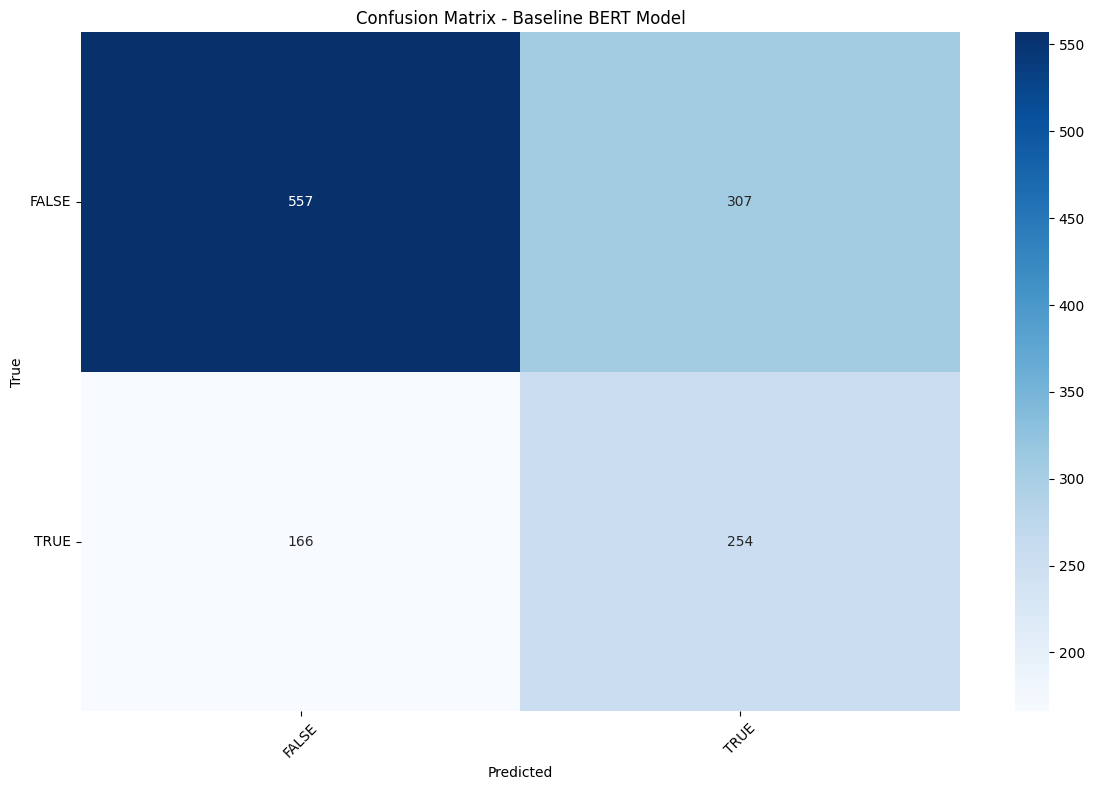

Adding metadata features...
Metadata features shape - Train: (10240, 4372), Valid: (1284, 4372)
Sample metadata columns: ['party_activist', 'party_business-leader', 'party_columnist', 'party_constitution-party', 'party_democrat', 'party_democratic-farmer-labor', 'party_education-official', 'party_government-body', 'party_green', 'party_independent']
Combined features shape - Train: (10240, 5140), Valid: (1284, 5140)
Training combined binary classification model (BERT + Metadata)...

Combined Model Results:
Accuracy: 0.6417
Improvement over baseline: 0.0101

Classification Report:
              precision    recall  f1-score   support

       FALSE       0.76      0.68      0.72       864
        TRUE       0.46      0.56      0.51       420

    accuracy                           0.64      1284
   macro avg       0.61      0.62      0.61      1284
weighted avg       0.66      0.64      0.65      1284



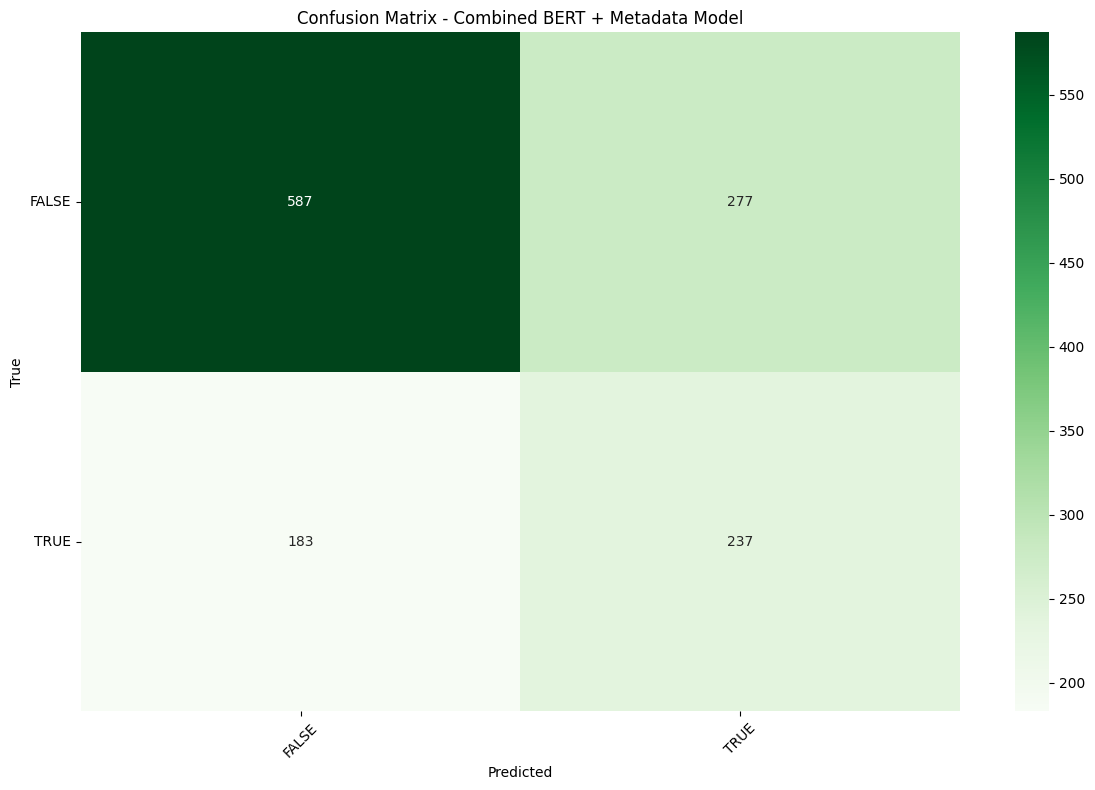

MODEL COMPARISON SUMMARY
Baseline (BERT only):           0.6316
Combined (BERT + Metadata):     0.6417
Metadata improvement:           0.0101

Hypothesis Testing (H0: accuracy ≤ 75%, H1: accuracy > 75%):
Baseline model: 811/1284 correct, p-value = 1.000000
Combined model: 824/1284 correct, p-value = 1.000000
❌ Fail to reject H0: No evidence that accuracy > 75%

TOP METADATA FEATURES FOR BINARY CLASSIFICATION
Features that predict TRUE (factual statements):
  context_a newspaper column: 1.8253
  context_a newspaper commentary: 1.5751
  context_a message on Twitter: 1.4507
  context_a speech at the American Enterprise Institute: 1.3804
  context_an online video: 1.3567
  context_an op-ed in the Tampa Bay Times: 1.3232
  context_an interview on Fox & Friends: 1.2887
  context_a prepared statement: 1.2768

Features that predict FALSE (misleading statements):
  context_a chain email: -1.6232
  state_Washington state: -1.2868
  context_a chain e-mail: -1.2358
  context_a public meeting: -1.1

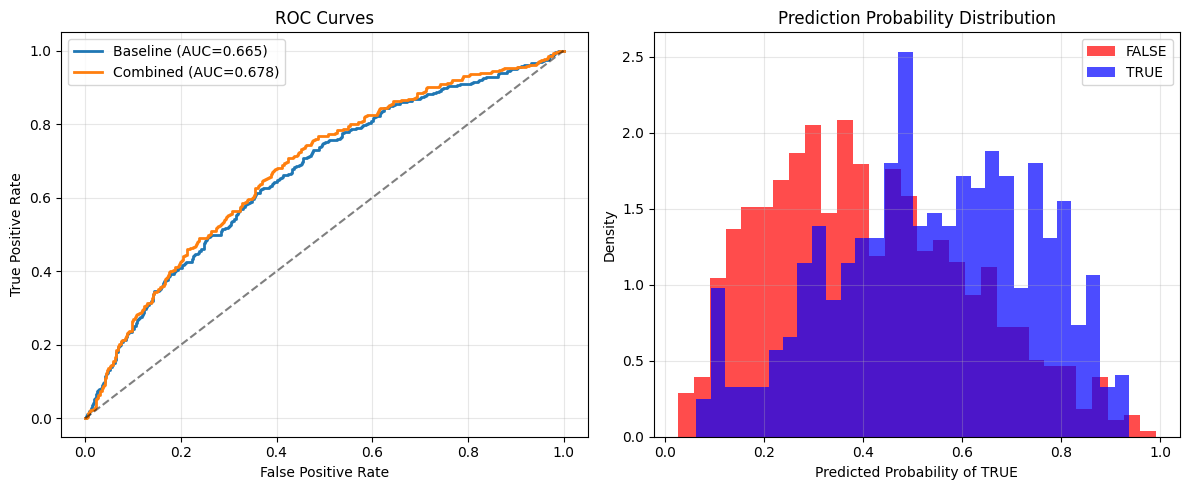


NEXT STEPS FOR IMPROVEMENT
1. Fine-tune BERT: Instead of using frozen BERT + LogReg, fine-tune BERT end-to-end
2. Try different models: RoBERTa, ELECTRA, or domain-specific models
3. Experiment with different pooling strategies (mean, max, attention)
4. Add more metadata features: speaker history, statement length, etc.
5. Handle class imbalance: use class weights or SMOTE
6. Ensemble methods: combine multiple models

🎯 Binary classification results:
   Baseline accuracy: 0.632
   Combined accuracy: 0.642
⚠️  Close to target. Current: 0.642, Target: 0.75
   Need 0.108 more accuracy points
   Consider: fine-tuning BERT, ensemble methods, or more features

ANALYSIS COMPLETE


In [18]:
# ====================================
# LIAR Dataset Analysis with BERT
# ====================================

# ====================================
# 1. Setup & Installation
# ====================================
!pip install transformers torch scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import binomtest
from scipy.sparse import csr_matrix, hstack
import pickle
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ====================================
# 2. Load Data
# ====================================
# Upload your files to Colab first using:
# from google.colab import files
# uploaded = files.upload()

train_path = "train-train-clean.csv"
valid_path = "valid-valid-clean.csv"

# Load CSV files
train_df = pd.read_csv(train_path, header=None, engine="python")
valid_df = pd.read_csv(valid_path, header=None, engine="python")

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)

# ====================================
# 3. Assign Column Names
# ====================================
cols = [
    "id", "label", "statement",
    "speaker", "title", "state", "party",
    "num1", "num2", "num3", "num4", "num5",
    "context"
]
train_df.columns = cols
valid_df.columns = cols

print("Sample data:")
print(train_df[['label', 'statement', 'party', 'state']].head())

# ====================================
# 4. Clean and Process Text Data
# ====================================
def clean_text(text):
    """Clean text by handling NaN and basic preprocessing"""
    if pd.isna(text):
        return ""
    return str(text).strip()

train_df['statement_clean'] = train_df['statement'].apply(clean_text)
valid_df['statement_clean'] = valid_df['statement'].apply(clean_text)

print(f"Sample cleaned statements:")
for i in range(3):
    print(f"{i+1}: {train_df['statement_clean'].iloc[i][:100]}...")

# ====================================
# 5. Binary Label Simplification & Encoding
# ====================================
def simplify_to_binary(label):
    """
    Simplify multi-class labels to binary:
    - 'true', 'mostly-true' → 'TRUE'
    - 'half-true', 'barely-true', 'false', 'pants-fire' → 'FALSE'
    """
    if label.lower() in ['true', 'mostly-true']:
        return 'TRUE'
    else:
        return 'FALSE'

# Apply binary simplification
train_df['label_binary'] = train_df['label'].apply(simplify_to_binary)
valid_df['label_binary'] = valid_df['label'].apply(simplify_to_binary)

print("Original label distribution:")
print(train_df['label'].value_counts())
print(f"\nBinary label distribution:")
print(train_df['label_binary'].value_counts())

# Encode binary labels
le = LabelEncoder()
train_df["label_enc"] = le.fit_transform(train_df["label_binary"])
valid_df["label_enc"] = le.transform(valid_df["label_binary"])

print(f"\nBinary classes: {list(le.classes_)}")
print(f"Class balance: {train_df['label_binary'].value_counts(normalize=True).round(3).to_dict()}")

# ====================================
# 6. BERT Text Encoding
# ====================================
# Use DistilBERT (smaller, faster than full BERT)
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)
bert_model.to(device)
bert_model.eval()

def get_bert_embeddings(texts, batch_size=16, max_length=512):
    """
    Get BERT embeddings for a list of texts
    Returns: numpy array of shape (len(texts), 768) for DistilBERT
    """
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenize batch
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        # Move to device
        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Get embeddings
        with torch.no_grad():
            outputs = bert_model(**inputs)
            # Use [CLS] token embedding (first token)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

print("Generating BERT embeddings for training data...")
X_train_bert = get_bert_embeddings(train_df['statement_clean'].tolist())
print(f"Training embeddings shape: {X_train_bert.shape}")

print("Generating BERT embeddings for validation data...")
X_valid_bert = get_bert_embeddings(valid_df['statement_clean'].tolist())
print(f"Validation embeddings shape: {X_valid_bert.shape}")

y_train = train_df["label_enc"].values
y_valid = valid_df["label_enc"].values

# ====================================
# 7. Build Baseline Model: Binary Logistic Regression with BERT
# ====================================
print("Training baseline binary classification model with BERT features...")
baseline_model = LogisticRegression(
    max_iter=1000,
    solver="liblinear",  # Good for binary classification
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

baseline_model.fit(X_train_bert, y_train)
y_pred_baseline = baseline_model.predict(X_valid_bert)

baseline_accuracy = accuracy_score(y_valid, y_pred_baseline)
print(f"\nBaseline BERT Model Results:")
print(f"Accuracy: {baseline_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_valid, y_pred_baseline, target_names=le.classes_))

# ====================================
# 8. Confusion Matrix for Baseline
# ====================================
plt.figure(figsize=(12, 8))
cm_baseline = confusion_matrix(y_valid, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Baseline BERT Model")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ====================================
# 9. Supplement with Metadata Features
# ====================================
print("Adding metadata features...")

# Create metadata features (one-hot encoding)
meta_df_train = pd.get_dummies(
    train_df[["party", "state", "context"]].fillna("unknown"),
    drop_first=True
).astype(float)

meta_df_valid = pd.get_dummies(
    valid_df[["party", "state", "context"]].fillna("unknown"),
    drop_first=True
).astype(float)

# Align columns between train and validation
meta_df_valid = meta_df_valid.reindex(columns=meta_df_train.columns, fill_value=0.0)

print(f"Metadata features shape - Train: {meta_df_train.shape}, Valid: {meta_df_valid.shape}")
print(f"Sample metadata columns: {meta_df_train.columns[:10].tolist()}")

# Combine BERT embeddings with metadata
X_train_combined = np.hstack([X_train_bert, meta_df_train.values])
X_valid_combined = np.hstack([X_valid_bert, meta_df_valid.values])

print(f"Combined features shape - Train: {X_train_combined.shape}, Valid: {X_valid_combined.shape}")

# ====================================
# 10. Train Combined Model (BERT + Metadata) - Binary
# ====================================
print("Training combined binary classification model (BERT + Metadata)...")
combined_model = LogisticRegression(
    max_iter=1000,
    solver="liblinear",  # Good for binary classification
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

combined_model.fit(X_train_combined, y_train)
y_pred_combined = combined_model.predict(X_valid_combined)

combined_accuracy = accuracy_score(y_valid, y_pred_combined)
print(f"\nCombined Model Results:")
print(f"Accuracy: {combined_accuracy:.4f}")
print(f"Improvement over baseline: {combined_accuracy - baseline_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_valid, y_pred_combined, target_names=le.classes_))

# ====================================
# 11. Confusion Matrix for Combined Model
# ====================================
plt.figure(figsize=(12, 8))
cm_combined = confusion_matrix(y_valid, y_pred_combined)
sns.heatmap(cm_combined, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Combined BERT + Metadata Model")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ====================================
# 12. Model Comparison
# ====================================
print("="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
print(f"Baseline (BERT only):           {baseline_accuracy:.4f}")
print(f"Combined (BERT + Metadata):     {combined_accuracy:.4f}")
print(f"Metadata improvement:           {combined_accuracy - baseline_accuracy:.4f}")
print("="*50)

# ====================================
# 13. Hypothesis Testing
# ====================================
n_samples = len(y_valid)
correct_baseline = sum(y_pred_baseline == y_valid)
correct_combined = sum(y_pred_combined == y_valid)

# H0: accuracy ≤ 0.75, H1: accuracy > 0.75
test_baseline = binomtest(correct_baseline, n_samples, p=0.75, alternative="greater")
test_combined = binomtest(correct_combined, n_samples, p=0.75, alternative="greater")

print("\nHypothesis Testing (H0: accuracy ≤ 75%, H1: accuracy > 75%):")
print(f"Baseline model: {correct_baseline}/{n_samples} correct, p-value = {test_baseline.pvalue:.6f}")
print(f"Combined model: {correct_combined}/{n_samples} correct, p-value = {test_combined.pvalue:.6f}")

if test_combined.pvalue < 0.05:
    print("✅ Reject H0: Model accuracy significantly > 75%")
else:
    print("❌ Fail to reject H0: No evidence that accuracy > 75%")

# ====================================
# 14. Feature Interpretation - Binary Classification
# ====================================
def get_top_metadata_features_binary(model, metadata_columns, top_k=10):
    """Extract top metadata features for binary classification"""
    # For binary classification, we only have one coefficient vector
    # Metadata features start after BERT embeddings (768 features for DistilBERT)
    bert_embedding_dim = 768
    metadata_coefs = model.coef_[0][bert_embedding_dim:]  # Shape: (n_metadata_features,)

    # Get top positive and negative coefficients
    top_pos_idx = np.argsort(metadata_coefs)[-top_k:][::-1]
    top_neg_idx = np.argsort(metadata_coefs)[:top_k]

    top_pos_features = [(metadata_columns[j], metadata_coefs[j]) for j in top_pos_idx if metadata_coefs[j] > 0.01]
    top_neg_features = [(metadata_columns[j], metadata_coefs[j]) for j in top_neg_idx if metadata_coefs[j] < -0.01]

    return top_pos_features, top_neg_features

# Analyze metadata feature importance for binary classification
if combined_accuracy > baseline_accuracy:
    print("\n" + "="*60)
    print("TOP METADATA FEATURES FOR BINARY CLASSIFICATION")
    print("="*60)

    pos_features, neg_features = get_top_metadata_features_binary(
        combined_model,
        meta_df_train.columns.tolist(),
        top_k=8
    )

    print(f"Features that predict TRUE (factual statements):")
    for feat, coef in pos_features:
        print(f"  {feat}: {coef:.4f}")

    print(f"\nFeatures that predict FALSE (misleading statements):")
    for feat, coef in neg_features:
        print(f"  {feat}: {coef:.4f}")

    # Additional analysis - BERT vs Metadata contribution
    print(f"\nBERT vs Metadata contribution:")
    bert_embedding_dim = 768  # DistilBERT embedding dimension
    bert_coefs = combined_model.coef_[0][:bert_embedding_dim]
    meta_coefs = combined_model.coef_[0][bert_embedding_dim:]

    print(f"  BERT features mean absolute weight: {np.mean(np.abs(bert_coefs)):.4f}")
    print(f"  Metadata features mean absolute weight: {np.mean(np.abs(meta_coefs)):.4f}")

    # Feature importance ratio
    bert_importance = np.sum(np.abs(bert_coefs))
    meta_importance = np.sum(np.abs(meta_coefs))
    total_importance = bert_importance + meta_importance

    print(f"  BERT contribution: {bert_importance/total_importance:.1%}")
    print(f"  Metadata contribution: {meta_importance/total_importance:.1%}")

# ====================================
# 15. Save Models and Results
# ====================================
artifacts = {
    'tokenizer': tokenizer,
    'bert_model_name': model_name,
    'label_encoder': le,
    'baseline_model': baseline_model,
    'combined_model': combined_model,
    'metadata_columns': meta_df_train.columns.tolist(),
    'baseline_accuracy': baseline_accuracy,
    'combined_accuracy': combined_accuracy,
    'results': {
        'baseline_predictions': y_pred_baseline,
        'combined_predictions': y_pred_combined,
        'true_labels': y_valid
    }
}

with open('liar_bert_artifacts.pkl', 'wb') as f:
    pickle.dump(artifacts, f)

print(f"\n✅ Models and results saved to 'liar_bert_artifacts.pkl'")

# ====================================
# 16. Performance Analysis - Binary Classification
# ====================================
print("\n" + "="*60)
print("DETAILED BINARY CLASSIFICATION ANALYSIS")
print("="*60)

# Binary classification metrics
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve

# Get prediction probabilities for AUC
y_proba_baseline = baseline_model.predict_proba(X_valid_bert)[:, 1]
y_proba_combined = combined_model.predict_proba(X_valid_combined)[:, 1]

# Calculate AUC scores
auc_baseline = roc_auc_score(y_valid, y_proba_baseline)
auc_combined = roc_auc_score(y_valid, y_proba_combined)

print(f"ROC-AUC Scores:")
print(f"  Baseline (BERT only):     {auc_baseline:.4f}")
print(f"  Combined (BERT + Meta):   {auc_combined:.4f}")

# Precision, Recall, F1 for each class
precision, recall, f1, support = precision_recall_fscore_support(y_valid, y_pred_combined, average=None)

print(f"\nDetailed Performance (Combined Model):")
for i, class_name in enumerate(le.classes_):
    print(f"  {class_name:5}: P={precision[i]:.3f}, R={recall[i]:.3f}, F1={f1[i]:.3f} (n={support[i]})")

# Overall metrics
print(f"\nOverall Performance:")
print(f"  Macro F1:        {np.mean(f1):.4f}")
print(f"  Weighted F1:     {f1.mean():.4f}")

# ROC Curve visualization
plt.figure(figsize=(12, 5))

# ROC curves
plt.subplot(1, 2, 1)
fpr_baseline, tpr_baseline, _ = roc_curve(y_valid, y_proba_baseline)
fpr_combined, tpr_combined, _ = roc_curve(y_valid, y_proba_combined)

plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC={auc_baseline:.3f})', linewidth=2)
plt.plot(fpr_combined, tpr_combined, label=f'Combined (AUC={auc_combined:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Probability distribution
plt.subplot(1, 2, 2)
plt.hist(y_proba_combined[y_valid == 0], bins=30, alpha=0.7, label='FALSE', color='red', density=True)
plt.hist(y_proba_combined[y_valid == 1], bins=30, alpha=0.7, label='TRUE', color='blue', density=True)
plt.xlabel('Predicted Probability of TRUE')
plt.ylabel('Density')
plt.title('Prediction Probability Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ====================================
# 17. Next Steps and Recommendations
# ====================================
print("\n" + "="*60)
print("NEXT STEPS FOR IMPROVEMENT")
print("="*60)
print("1. Fine-tune BERT: Instead of using frozen BERT + LogReg, fine-tune BERT end-to-end")
print("2. Try different models: RoBERTa, ELECTRA, or domain-specific models")
print("3. Experiment with different pooling strategies (mean, max, attention)")
print("4. Add more metadata features: speaker history, statement length, etc.")
print("5. Handle class imbalance: use class weights or SMOTE")
print("6. Ensemble methods: combine multiple models")

print(f"\n🎯 Binary classification results:")
print(f"   Baseline accuracy: {baseline_accuracy:.3f}")
print(f"   Combined accuracy: {combined_accuracy:.3f}")

if combined_accuracy >= 0.75:
    print(f"✅ TARGET ACHIEVED! Accuracy ({combined_accuracy:.3f}) ≥ 75%")
    print("   Binary simplification was successful!")
else:
    print(f"⚠️  Close to target. Current: {combined_accuracy:.3f}, Target: 0.75")
    print(f"   Need {0.75 - combined_accuracy:.3f} more accuracy points")
    print("   Consider: fine-tuning BERT, ensemble methods, or more features")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)